In [1]:
import matplotlib.pyplot as plt
import torch
import time

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from tqdm import trange

In [2]:
class Dataset(torch.utils.data.Dataset):
    """
    Class overloading the torch.utils.data.Dataset class to 
    create a custom dataset object
    """
    def __init__ (self, images, labels):
        self.images = images.float()
        self.labels = labels.long()


    def __len__ (self): 
        return(len(self.images))

    def __getitem__ (self, idx):
        return self.images[idx], self.labels[idx]
    
    def shuffle(self):
        idx = torch.randperm(self.__len__())
        self.images = self.images[idx]
        self.labels = self.labels[idx]
    
    def train_val_test_split(self, train_percentage=0.7, val_percentage=0.15, test_percentage=0.15):
        # split the data
        self.shuffle()
        train_data = self[:int(train_percentage*self.__len__())]
        val_data = self[int(train_percentage*self.__len__()):int((train_percentage+val_percentage)*self.__len__())]
        test_data = self[int((train_percentage+val_percentage)*self.__len__()):]
        return Dataset(train_data[0], train_data[1]), Dataset(val_data[0], val_data[1]), Dataset(test_data[0], test_data[1])

In [3]:
# load the data
data = torch.load('data/BrainCancerDataset.pt')

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [5]:
class BrainClassifier(nn.Module):
    def __init__(self):
        super(BrainClassifier, self).__init__()

        # Define layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)  # Grayscale images
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()

        # Calculate the input size of the fully connected layer according to the output of the conv layers
        fc_input_size = 64 * 64 * 64  # Ensure this calculation matches the output size of the conv layers
        self.fc = nn.Linear(fc_input_size, 3)  # 3 classes

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = F.relu(self.conv3(x))
        x = self.pool3(x)

        x = self.flatten(x)

        x = self.fc(x)
        return x

In [6]:
# Define the training loop
def train(model, train_data, val_data, epochs=10, lr=0.001):
    # Define the loss function
    criterion = nn.CrossEntropyLoss()
    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Store the losses
    train_losses = []
    val_losses = []

    # Move model to the appropriate device
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in trange(epochs):
        # Set the model to training mode
        model.train()

        # Iterate over the training data
        for i, (img, label) in enumerate(train_data):
            # Move data to the appropriate device
            img, label = img.to(device), label.to(device)

            # Zero the gradients
            optimizer.zero_grad()
            # Forward pass
            y_pred = model(img)
            # Compute the loss
            loss = criterion(y_pred, label.long())
            # Backward pass
            loss.backward()
            # Update the weights
            optimizer.step()
            # Store the loss
            train_losses.append(loss.item())
            # Print the loss
            # if i % 10 == 0:
            #     print(f'Epoch {epoch}, Iteration {i}, Loss {loss.item()}')

        # Set the model to evaluation mode
        model.eval()
        # Compute the validation loss
        val_loss = 0
        with torch.no_grad():
            for img, label in val_data:
                # Move data to the appropriate device
                img, label = img.to(device), label.to(device)
                y_pred = model(img)
                loss = criterion(y_pred, label.long())
                val_loss += loss.item()

        val_losses.append(val_loss / len(val_data))

        if epoch % 5 == 0:
            print(f'Epoch {epoch}, Validation Loss {val_loss / len(val_data)}')

    return train_losses, val_losses

In [7]:
#  set the seed before the split
torch.manual_seed(42)
data_train, data_val, data_test = data.train_val_test_split()

# Create the DataLoaders
train_loader = DataLoader(data_train, batch_size=32, shuffle=True)
val_loader = DataLoader(data_val, batch_size=32, shuffle=False)
test_loader = DataLoader(data_test, batch_size=data_test.__len__(), shuffle=False)


In [8]:
# Example instantiation and trainin
model = BrainClassifier()
tstart = time.time()

train_losses, val_losses = train(model, train_loader, val_loader, epochs=150, lr=0.00001)

tend = time.time()
print("Time elapsed: ", tend-tstart)

  0%|                                                                             | 0/150 [00:00<?, ?it/s]/orfeo/cephfs/home/dssc/ipasia00/deepenv/lib64/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Attempt to open cnn_infer failed: handle=0 error: libcudnn_cnn_infer.so.8: cannot open shared object file: No such file or directory (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:81.)
  return F.conv2d(input, weight, bias, self.stride,
  1%|▍                                                                    | 1/150 [00:04<10:17,  4.14s/it]

Epoch 0, Validation Loss 12.572970294952393


  4%|██▊                                                                  | 6/150 [00:23<09:24,  3.92s/it]

Epoch 5, Validation Loss 1.4946290463209153


  7%|████▉                                                               | 11/150 [00:43<09:12,  3.98s/it]

Epoch 10, Validation Loss 1.3092895597219467


 11%|███████▎                                                            | 16/150 [01:02<08:44,  3.92s/it]

Epoch 15, Validation Loss 1.340690127015114


 14%|█████████▌                                                          | 21/150 [01:22<08:23,  3.90s/it]

Epoch 20, Validation Loss 1.0366615740310712


 17%|███████████▊                                                        | 26/150 [01:41<08:03,  3.90s/it]

Epoch 25, Validation Loss 1.0226017453610743


 21%|██████████████                                                      | 31/150 [02:01<07:44,  3.90s/it]

Epoch 30, Validation Loss 1.0279154591958408


 24%|████████████████▎                                                   | 36/150 [02:21<07:25,  3.91s/it]

Epoch 35, Validation Loss 1.0291456214989012


 27%|██████████████████▌                                                 | 41/150 [02:40<07:11,  3.96s/it]

Epoch 40, Validation Loss 1.0231024594019498


 31%|████████████████████▊                                               | 46/150 [03:00<06:48,  3.92s/it]

Epoch 45, Validation Loss 1.026493367771036


 34%|███████████████████████                                             | 51/150 [03:20<06:36,  4.00s/it]

Epoch 50, Validation Loss 1.0239597883024545


 37%|█████████████████████████▍                                          | 56/150 [03:39<06:09,  3.93s/it]

Epoch 55, Validation Loss 1.0376532736278024


 41%|███████████████████████████▋                                        | 61/150 [03:59<05:58,  4.03s/it]

Epoch 60, Validation Loss 1.0295931051625908


 44%|█████████████████████████████▉                                      | 66/150 [04:19<05:32,  3.96s/it]

Epoch 65, Validation Loss 1.0319718005099277


 47%|████████████████████████████████▏                                   | 71/150 [04:39<05:09,  3.92s/it]

Epoch 70, Validation Loss 1.0381546524717122


 51%|██████████████████████████████████▍                                 | 76/150 [04:58<04:49,  3.91s/it]

Epoch 75, Validation Loss 1.0515651549312073


 54%|████████████████████████████████████▋                               | 81/150 [05:18<04:29,  3.91s/it]

Epoch 80, Validation Loss 1.0542428816218792


 57%|██████████████████████████████████████▉                             | 86/150 [05:37<04:10,  3.91s/it]

Epoch 85, Validation Loss 1.047187818189074


 61%|█████████████████████████████████████████▎                          | 91/150 [05:57<03:50,  3.91s/it]

Epoch 90, Validation Loss 1.0445309011653687


 64%|███████████████████████████████████████████▌                        | 96/150 [06:17<03:31,  3.91s/it]

Epoch 95, Validation Loss 1.0392744418544073


 67%|█████████████████████████████████████████████                      | 101/150 [06:36<03:11,  3.91s/it]

Epoch 100, Validation Loss 1.0383180345719059


 71%|███████████████████████████████████████████████▎                   | 106/150 [06:56<02:51,  3.91s/it]

Epoch 105, Validation Loss 1.0688616514671594


 74%|█████████████████████████████████████████████████▌                 | 111/150 [07:15<02:32,  3.91s/it]

Epoch 110, Validation Loss 1.0915605598284552


 77%|███████████████████████████████████████████████████▊               | 116/150 [07:35<02:12,  3.91s/it]

Epoch 115, Validation Loss 1.0993821723076205


 81%|██████████████████████████████████████████████████████             | 121/150 [07:54<01:53,  3.91s/it]

Epoch 120, Validation Loss 1.1357674402650446


 84%|████████████████████████████████████████████████████████▎          | 126/150 [08:14<01:33,  3.90s/it]

Epoch 125, Validation Loss 1.1295316942346594


 87%|██████████████████████████████████████████████████████████▌        | 131/150 [08:33<01:14,  3.90s/it]

Epoch 130, Validation Loss 1.1551992079708726


 91%|████████████████████████████████████████████████████████████▋      | 136/150 [08:53<00:54,  3.90s/it]

Epoch 135, Validation Loss 1.1720994872584318


 94%|██████████████████████████████████████████████████████████████▉    | 141/150 [09:12<00:35,  3.90s/it]

Epoch 140, Validation Loss 1.1727476298809052


 97%|█████████████████████████████████████████████████████████████████▏ | 146/150 [09:32<00:15,  3.90s/it]

Epoch 145, Validation Loss 1.2016933927312494


100%|███████████████████████████████████████████████████████████████████| 150/150 [09:48<00:00,  3.92s/it]

Time elapsed:  588.1084904670715


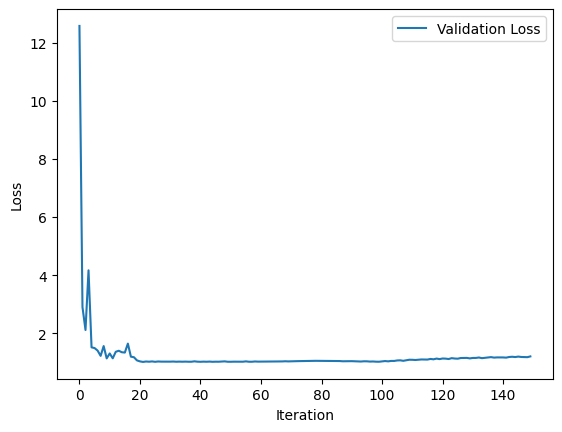

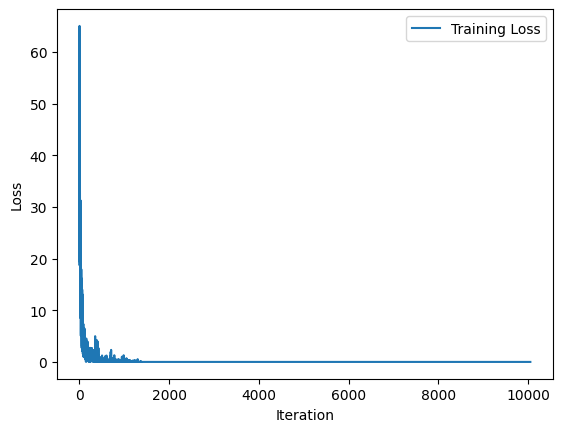

In [9]:
# plot the losses
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.plot(train_losses, label='Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [10]:
# Save the model weights
torch.save(model.state_dict(), 'Brain_weights.pth')

In [11]:
x, y = next(iter(test_loader))
model.eval()
y_pred = model(x.to(device)).argmax(1)
# y --> label vere
# y_pred --> label modello

In [12]:
# compute the accuracy
correct = 0
total = 0
with torch.no_grad():
    for img, label in test_loader:
        img, label = img.to(device), label.to(device)
        y_pred = model(img)
        correct += (y_pred.argmax(1) == label).sum().item()
        total += label.size(0)

print(f'Accuracy: {correct / total}')

Accuracy: 0.8973799126637555


In [14]:
model2 = BrainClassifier()
model2 = model2.to(device)
model2.eval()

correct = 0
total = 0
with torch.no_grad():
    for img, label in test_loader:
        img, label = img.to(device), label.to(device)
        y_pred = model2(img.float().to(device))
        correct += (y_pred.argmax(1) == label).sum().item()
        total += label.size(0)

print(f'Accuracy: {correct / total}')

Accuracy: 0.29475982532751094
